# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path: 
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
    ## I have to resolve a little issue with my installation of opencv and the python path env
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


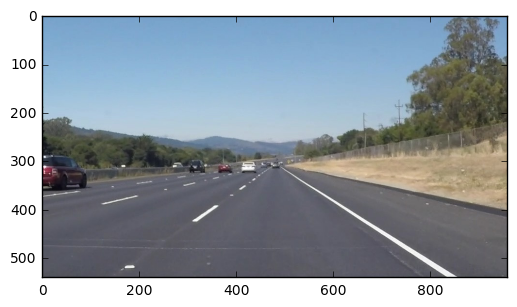

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    range_slope = [0.5,0.75]
    positive_b = []
    negative_b = []
    positive_slopes = []
    negative_slopes = []
    imshape = img.shape
    ymin = imshape[1]
    for line in lines:
        x1 = line[0][0]
        x2 = line[0][2]
        y1 = line[0][1]
        y2 = line[0][3]
        cv2.line(img, (x1, y1), (x2,y2), color, 15)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Define pipeline:

In [8]:
# Read in and grayscale the image
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
kernel_size = 3
low_threshold = 50
high_threshold = 150

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 50 #minimum number of pixels making up a line
max_line_gap = 100    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

def process_image(img,kernel_size=5,low_threshold=50,high_threshold=150,rho=2,
                  theta=np.pi/180,threshold=15,min_line_lengh=40,max_line_gap=20,line_image=line_image,
                  vertices=[],debug = False,save_file=False):
    '''
    This function identifies road lines in an image.
    
    Args:
         * img: image to process
         * kernel_size: kernel used in the gaussian distribution
         * low_threshold: Canny threshold (low)
         * high_threshold: Canny threshold (high)
         * rho: distance resolution in pixels of the Hough grid
         * theta: angular resolution in radians of the Hough grid
         * threshold: minimum number of votes (intersections in Hough grid cell)
         * min_line_lengh: minimum number of pixels making up a line
         * max_line_gap: maximum gap in pixels between connectable line segments
         * line_image: creating a blank to draw lines on
         * vertices: area of interest
         * debug = True
    Return:
        Processed image with road lines identified and highlighted in red.
    '''
    img_gray = grayscale(img)
    if debug:
        print ("grey image:")
        plt.imshow(img_gray, cmap='Greys_r')
        plt.show()
    img_gaussian = gaussian_blur(img_gray, kernel_size)
    if debug:
        print ("Gaussian Process:")
        plt.imshow(img_gaussian, cmap='Greys_r')
        plt.show()
    edges = canny(img_gaussian, low_threshold, high_threshold)
    if debug:
        print ("Canny Process:")
        plt.imshow(edges, cmap='Greys_r')
        plt.show()
    img_region = region_of_interest(edges, vertices)
    if debug:
        print ("Selected region of interest:")
        plt.imshow(img_region, cmap='Greys_r')
        plt.show()
    lines = hough_lines(img_region, rho, theta, threshold, min_line_len, max_line_gap)
    processed_img = weighted_img(lines, img, α=0.8, β=1., λ=0.)
    x = [vertices[0][0][0], vertices[0][1][0], vertices[0][2][0], vertices[0][3][0]]
    y = [vertices[0][0][1], vertices[0][1][1], vertices[0][2][1], vertices[0][3][1]]
    plt.imshow(processed_img)
    plt.plot(x, y, 'b--', lw=3)
    if save_file: plt.savefig(img_path.replace(".jpg","_processed.jpg"))
    if debug:
        print ("Final Result:")
        plt.show()
    plt.close()
    return 

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
import os
os.listdir("test_images/")


['whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

whiteCarLaneSwitch.jpg
grey image:


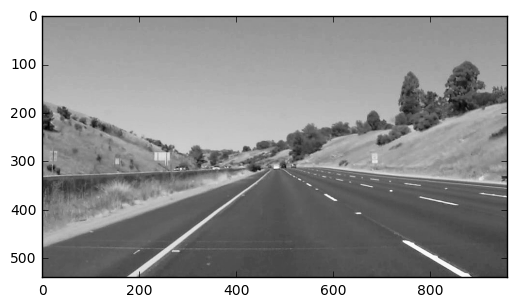

Gaussian Process:


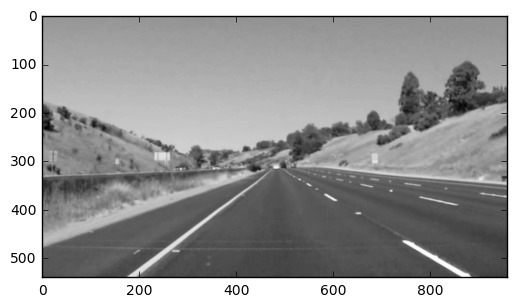

Canny Process:


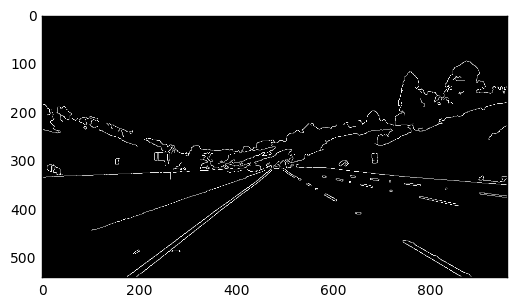

Selected region of interest:


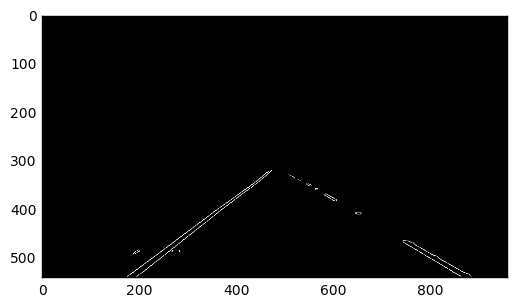

Final Result:


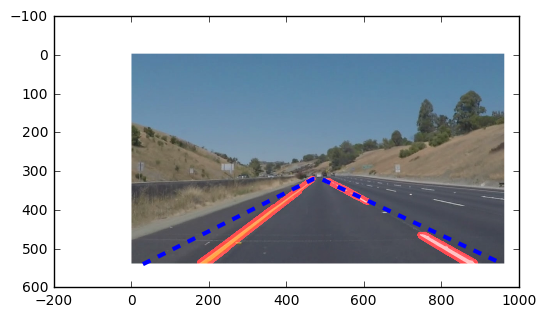

solidWhiteRight.jpg
grey image:


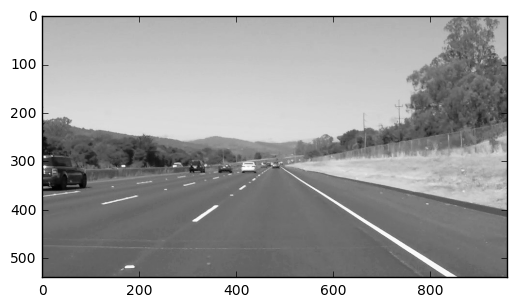

Gaussian Process:


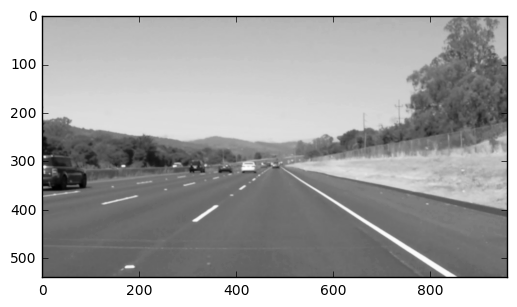

Canny Process:


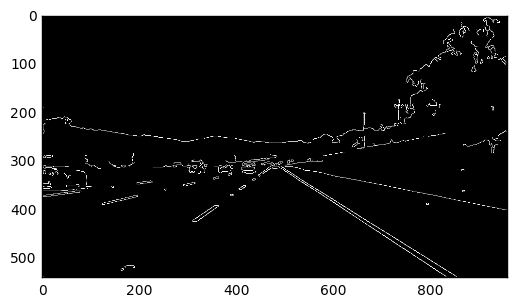

Selected region of interest:


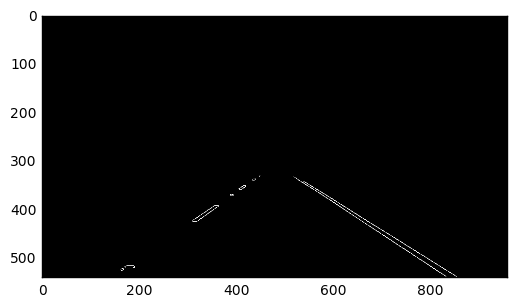

Final Result:


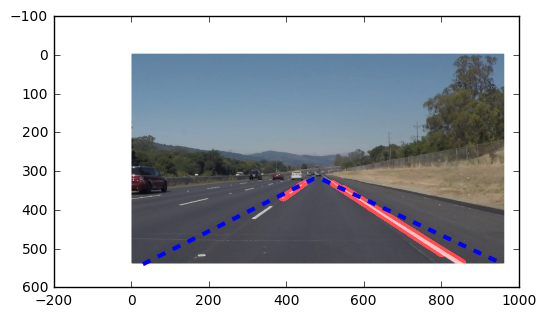

solidYellowCurve.jpg
grey image:


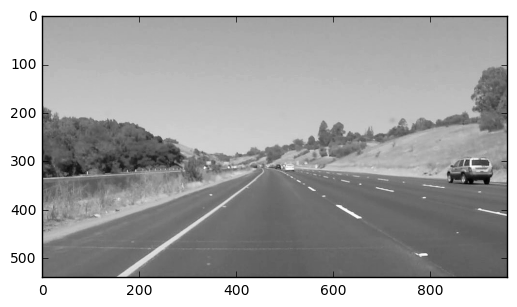

Gaussian Process:


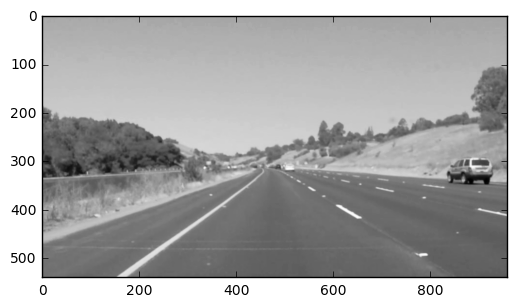

Canny Process:


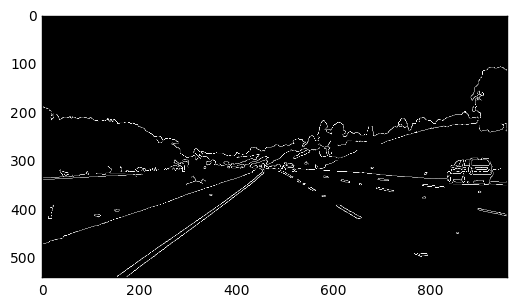

Selected region of interest:


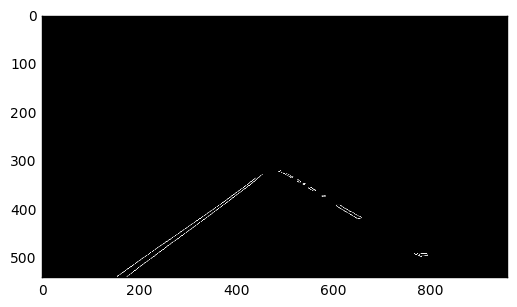

Final Result:


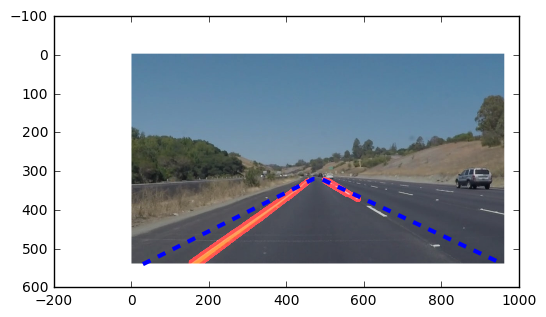

solidWhiteCurve.jpg
grey image:


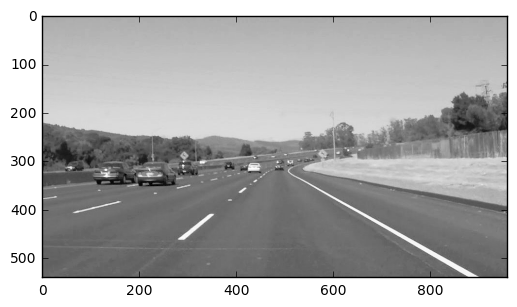

Gaussian Process:


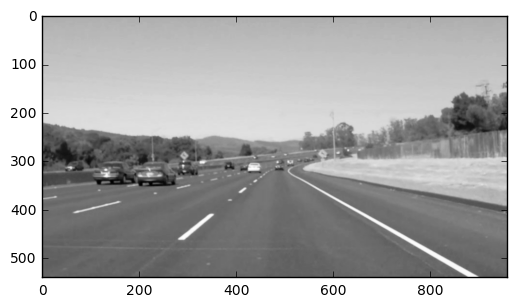

Canny Process:


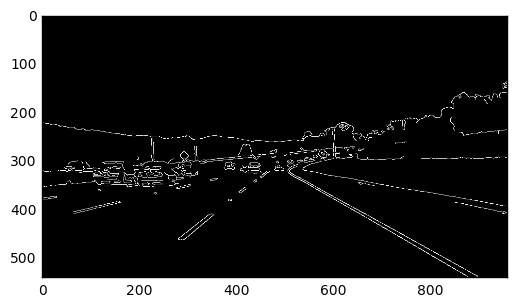

Selected region of interest:


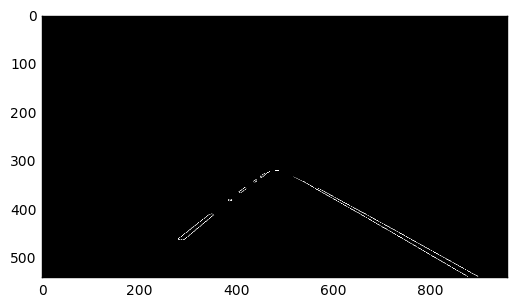

Final Result:


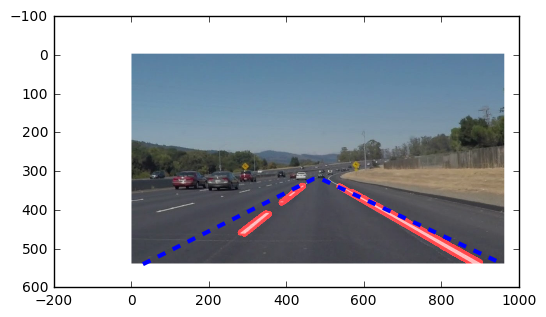

solidYellowLeft.jpg
grey image:


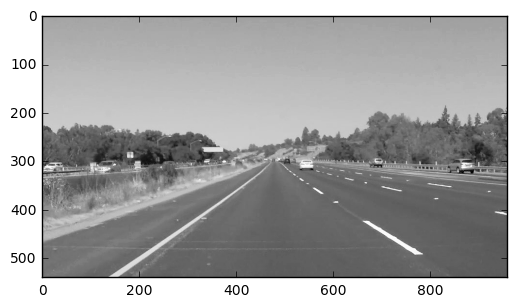

Gaussian Process:


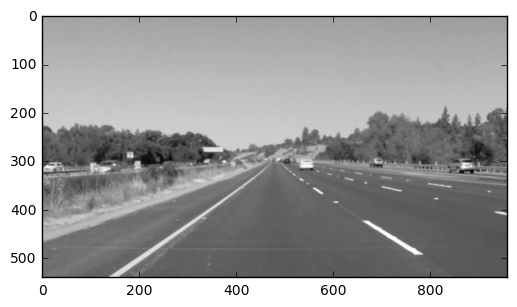

Canny Process:


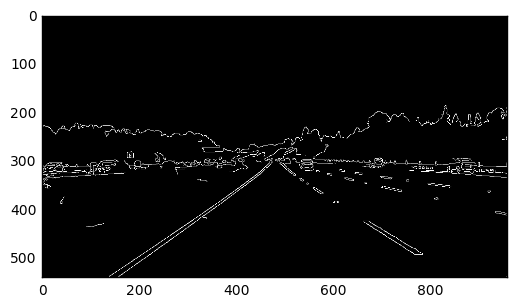

Selected region of interest:


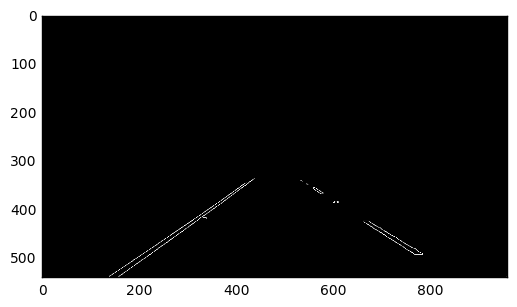

Final Result:


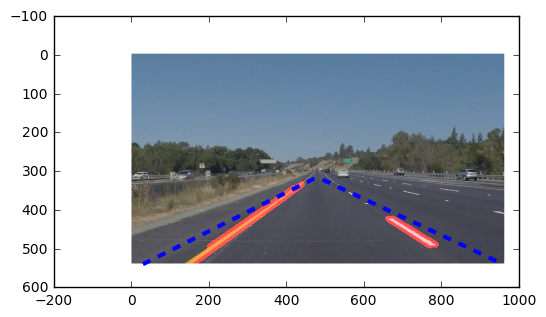

solidYellowCurve2.jpg
grey image:


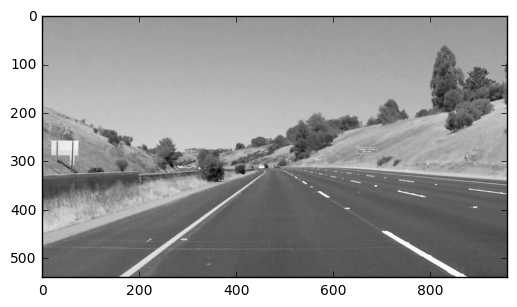

Gaussian Process:


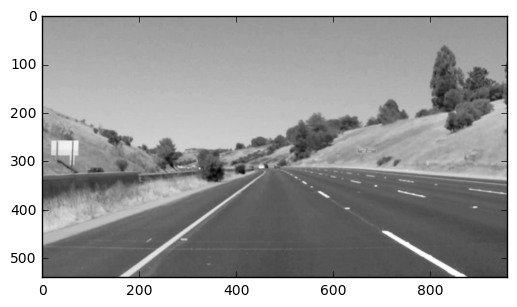

Canny Process:


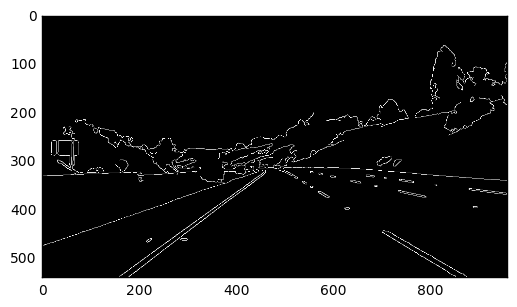

Selected region of interest:


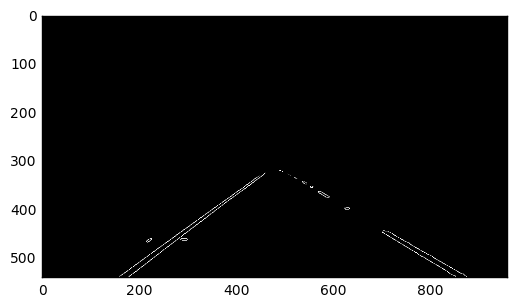

Final Result:


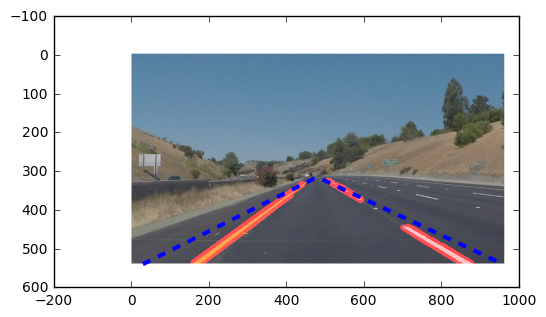

In [10]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
imgs = os.listdir("test_images/")
for i,img in enumerate(imgs):
    # Vertices:
    img_path = 'test_images/'+img
    if "processed" in img: continue
    print (img)
    img = mpimg.imread(img_path)
    imshape = img.shape
    vertices = np.array([[(30,imshape[0]),(470, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32) # Area of interest
    process_image(img,vertices = vertices,debug=True)



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(img):
    '''
    This function identifies road lines in an image.
    
    Args:
         * img: image

    Return:
        Processed image with road lines identified and highlighted in red.
    '''
    imshape = img.shape
    vertices = np.array([[(30,imshape[0]),(470, 310), (490, 310), (imshape[1],imshape[0])]], dtype=np.int32) # Area of interest
    img_gray = grayscale(img)
    img_gaussian = gaussian_blur(img_gray, kernel_size)
    edges = canny(img_gaussian, low_threshold, high_threshold)
    img_region = region_of_interest(edges, vertices)
    lines = hough_lines(img_region, rho, theta, threshold, min_line_len, max_line_gap)
    processed_img = weighted_img(lines, img, α=0.8, β=1., λ=0.)
    x = [vertices[0][0][0], vertices[0][1][0], vertices[0][2][0], vertices[0][3][0]]
    y = [vertices[0][0][1], vertices[0][1][1], vertices[0][2][1], vertices[0][3][1]]
    return processed_img

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 34.9 s, sys: 1.27 s, total: 36.2 s
Wall time: 13.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    range_slope = [0.5,0.75]
    positive_b = []
    negative_b = []
    positive_slopes = []
    negative_slopes = []
    imshape = img.shape
    ymin = imshape[1]
    for line in lines:
        x1 = line[0][0]
        x2 = line[0][2]
        y1 = line[0][1]
        y2 = line[0][3]
        if ymin > np.min([y1,y2]): ymin = np.min([y1,y2])
        fit_line = np.polyfit((x1, x2), (y1, y2), 1)
        current_slope = fit_line[0]
        current_b = fit_line[1]
        if np.abs(current_slope) < 0.4: continue
        if current_slope > 0:
            positive_slopes.append(np.round(current_slope,2))
            positive_b.append(np.round(current_b,2))   
        else:
            negative_slopes.append(current_slope)
            negative_b.append(current_b)
    pos_x0 = int((imshape[1]-np.mean(positive_b))/np.mean(positive_slopes))
    pos_x1 = int((ymin-np.mean(positive_b))/np.mean(positive_slopes))
    cv2.line(img, (pos_x0, imshape[1]), (pos_x1, ymin), color, 15)
    neg_x0 = int((imshape[1]-np.mean(negative_b))/np.mean(negative_slopes))
    neg_x1 = int((ymin-np.mean(negative_b))/np.mean(negative_slopes))
    cv2.line(img, (neg_x0, imshape[1]), (neg_x1, ymin), color, 15)

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:42<00:00, 15.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 59s, sys: 4.18 s, total: 2min 4s
Wall time: 43.8 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

**[ANSWER:]**
First limitation is the number of parameters predefined and unchangeables as the video advanced, vertices, Hough parameters and so on are already predefined and fixed for the images used for testing and it is not possible to change them to better adjust them as the car moves. Another drawback is the slope and b calculations, there is no a perfect correlation between images and the final result is not as smooth as desired. 

Apart of this, algorithm is designed to identify white lines, but what about cases where lines are not so clear or even are not included? or how to do in cases when there are white vehicles on front?, this is an important limitation for the current approach. To end, the whole approach is designed to match road lines, but road curves are significantly different and a linear approach is not sufficient. So, as a summary, the current approach seems to be adequate for an image analysis, but when working with live images, a more robust solution would be required.

Ways to improve the algorithm would be to include previous images calculations, for example previous values (lets say, images from the last second) of m and b could be used to smooth the m and b values calculated for a current image. Another way to improve the whole process would be a more thorough approximation to identify the Region of Interest, right now is completely made by hand, but an algorithm to identify the road segment would be an improvement, for example we would do this by analyzing the road color and surroundings. Adding deep learning techniques would allow also the identification of vehicles and so exclude them from the road lines calculations. 

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

**[ANSWER:]** It does very bad. Main problem it pretends to fit road segments to lines. In this case road segments are not lines but a different function. A way to improve the current approximation would be to fit these segments using a log function or similar instead of the line approximation.

Another option is to limitate the region of analysis to reduce the horizont and limitate the grid. This would be the solution implemented at the end.


In [14]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:32<00:00,  7.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 25s, sys: 3.18 s, total: 1min 28s
Wall time: 33.7 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

I created a picture from the video an tested the current implementation:

grey image:


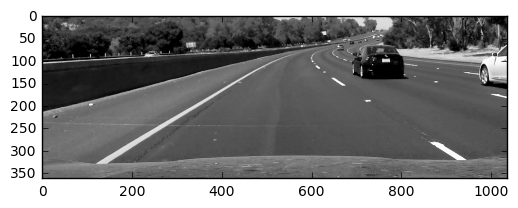

Gaussian Process:


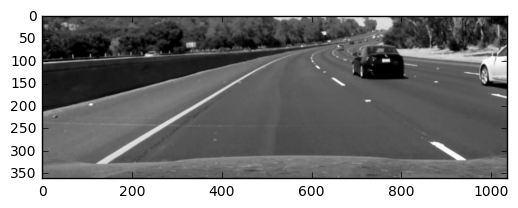

Canny Process:


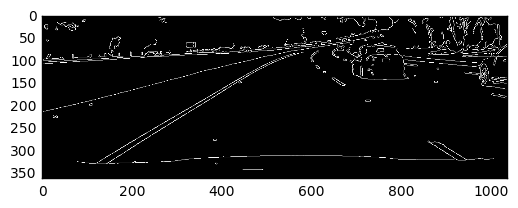

Selected region of interest:


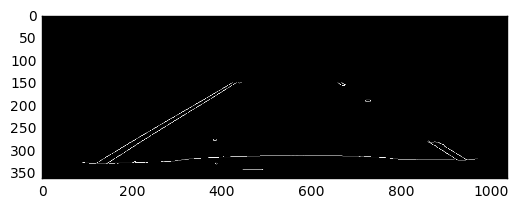

Final Result:


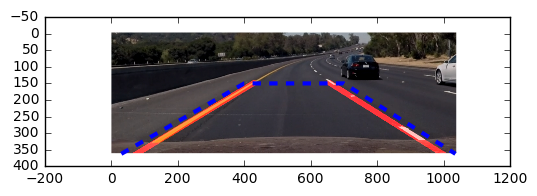

In [23]:
def process_image(img,kernel_size=5,low_threshold=50,high_threshold=150,rho=2,
                  theta=np.pi/180,threshold=15,min_line_lengh=40,max_line_gap=20,line_image=line_image,
                  vertices=[],debug = False,save_file=False):
    '''
    This function identifies road lines in an image.
    
    Args:
         * img: image to process
         * kernel_size: kernel used in the gaussian distribution
         * low_threshold: Canny threshold (low)
         * high_threshold: Canny threshold (high)
         * rho: distance resolution in pixels of the Hough grid
         * theta: angular resolution in radians of the Hough grid
         * threshold: minimum number of votes (intersections in Hough grid cell)
         * min_line_lengh: minimum number of pixels making up a line
         * max_line_gap: maximum gap in pixels between connectable line segments
         * line_image: creating a blank to draw lines on
         * vertices: area of interest
         * debug = True
    Return:
        Processed image with road lines identified and highlighted in red.
    '''
    img = mpimg.imread(img_path)
    img_gray = grayscale(img)
    if debug:
        print ("grey image:")
        plt.imshow(img_gray, cmap='Greys_r')
        plt.show()
    img_gaussian = gaussian_blur(img_gray, kernel_size)
    if debug:
        print ("Gaussian Process:")
        plt.imshow(img_gaussian, cmap='Greys_r')
        plt.show()
    edges = canny(img_gaussian, low_threshold, high_threshold)
    if debug:
        print ("Canny Process:")
        plt.imshow(edges, cmap='Greys_r')
        plt.show()
    img_region = region_of_interest(edges, vertices)
    if debug:
        print ("Selected region of interest:")
        plt.imshow(img_region, cmap='Greys_r')
        plt.show()
    lines = hough_lines(img_region, rho, theta, threshold, min_line_len, max_line_gap)
    processed_img = weighted_img(lines, img, α=0.8, β=1., λ=0.)
    x = [vertices[0][0][0], vertices[0][1][0], vertices[0][2][0], vertices[0][3][0]]
    y = [vertices[0][0][1], vertices[0][1][1], vertices[0][2][1], vertices[0][3][1]]
    plt.imshow(processed_img)
    plt.plot(x, y, 'b--', lw=3)
    if save_file: plt.savefig(img_path.replace(".jpg","_processed.jpg"))
    if debug:
        print ("Final Result:")
        plt.show()
    plt.close()
    return 

img_path = 'test_images/NotLineSegment.jpg'
img = mpimg.imread(img_path)
imshape = img.shape
vertices = np.array([[(30,imshape[0]),(400, 150), (700, 150), (imshape[1],imshape[0])]], dtype=np.int32) # Area of interest
process_image(img_path,vertices = vertices,debug=True)

In [36]:
def process_image(img):
    '''
    This function identifies road lines in an image.
    
    Args:
         * img: image

    Return:
        Processed image with road lines identified and highlighted in red.
    '''
    imshape = img.shape
    vertices = np.array([[(30,imshape[0]),(470, 300), (490, 300), (imshape[1],imshape[0])]], dtype=np.int32) # Area of interest
    img_gray = grayscale(img)
    img_gaussian = gaussian_blur(img_gray, kernel_size)
    edges = canny(img_gaussian, low_threshold, high_threshold)
    img_region = region_of_interest(edges, vertices)
    lines = hough_lines(img_region, rho, theta, threshold, min_line_len, max_line_gap)
    processed_img = weighted_img(lines, img, α=0.8, β=1., λ=0.)
    x = [vertices[0][0][0], vertices[0][1][0], vertices[0][2][0], vertices[0][3][0]]
    y = [vertices[0][0][1], vertices[0][1][1], vertices[0][2][1], vertices[0][3][1]]
    return processed_img


challenge_output = 'extra_parch.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)



[MoviePy] >>>> Building video extra_parch.mp4
[MoviePy] Writing video extra_parch.mp4





  0%|          | 0/251 [00:00<?, ?it/s]


  1%|          | 2/251 [00:00<00:15, 15.85it/s]


  2%|▏         | 4/251 [00:00<00:14, 16.77it/s]


  2%|▏         | 6/251 [00:00<00:14, 16.90it/s]


  3%|▎         | 8/251 [00:00<00:14, 17.14it/s]


  4%|▍         | 10/251 [00:00<00:14, 17.16it/s]


  5%|▍         | 12/251 [00:00<00:13, 17.33it/s]


  6%|▌         | 14/251 [00:00<00:13, 17.87it/s]


  6%|▋         | 16/251 [00:00<00:13, 17.58it/s]


  7%|▋         | 18/251 [00:01<00:13, 17.57it/s]


  8%|▊         | 20/251 [00:01<00:12, 17.79it/s]


  9%|▉         | 22/251 [00:01<00:12, 17.68it/s]


 10%|▉         | 24/251 [00:01<00:12, 17.78it/s]


 10%|█         | 26/251 [00:01<00:13, 16.87it/s]


 11%|█         | 28/251 [00:01<00:12, 17.46it/s]


 12%|█▏        | 30/251 [00:01<00:12, 17.41it/s]


 13%|█▎        | 32/251 [00:01<00:12, 17.74it/s]


 14%|█▎        | 34/251 [00:01<00:11, 18.09it/s]


 15%|█▍        | 37/251 [00:02<00:11, 18.71it/s]


 16%|█▌        | 39/251 [00:02<00:11, 18.

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra_parch.mp4 

CPU times: user 1min 30s, sys: 3.34 s, total: 1min 34s
Wall time: 38.5 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

Still need loooooot of improvement....